# 1. Import Dependencies and Data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from matplotlib import pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
ds = tfds.load('fashion_mnist', split='train')

In [3]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [4]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [5]:
# Getting data out of the pipeline
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

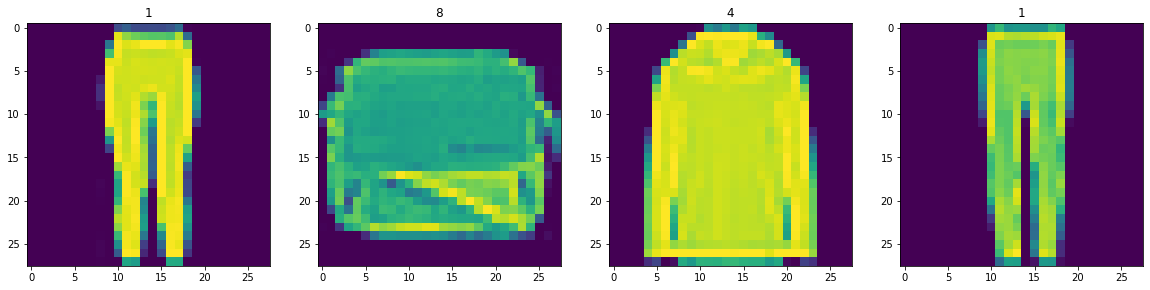

In [6]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [7]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

In [8]:
#images=tf.data.Dataset.list_files('data/images/*.jpg',shuffle=False)
#def load_img(x):
#    byte=tf.io.read_file(x)
#    img=tf.io.decode_jpeg(byte)
#    return img

ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [9]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [11]:
def build_generator(): 
    model = Sequential([
        # Takes in random values and reshapes it to 7x7x128
        # Beginnings of a generated image
        Dense(7*7*256, input_dim=256),
        LeakyReLU(0.2),
        Reshape((7,7,256)),

        UpSampling2D(),
        Conv2D(256, 5, padding='same'),
        LeakyReLU(0.2),
        
        UpSampling2D(),
        Conv2D(256, 5, padding='same'),
        LeakyReLU(0.2),

        Conv2D(256, 4, padding='same'),
        LeakyReLU(0.2),
        
        Conv2D(256, 4, padding='same'),
        LeakyReLU(0.2),
        
        # Conv layer to get to one channel
        Conv2D(1, 4, padding='same', activation='sigmoid')])
    
    return model

In [12]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             3223808   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 256)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 256)       1638656   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 256)       0         
                                                        

In [13]:
img = generator.predict(np.random.randn(4,256,1))
img

1/1 [==============================] - 4s 4s/step


array([[[[0.50919026],
         [0.5011322 ],
         [0.50389135],
         ...,
         [0.49920732],
         [0.49750635],
         [0.5009221 ]],

        [[0.51379734],
         [0.51550096],
         [0.5115184 ],
         ...,
         [0.50287545],
         [0.49986568],
         [0.5024215 ]],

        [[0.5056273 ],
         [0.508477  ],
         [0.5081411 ],
         ...,
         [0.50784266],
         [0.4998962 ],
         [0.50581294]],

        ...,

        [[0.50228745],
         [0.51166695],
         [0.51148283],
         ...,
         [0.49789673],
         [0.49781004],
         [0.5039452 ]],

        [[0.49778447],
         [0.5023688 ],
         [0.50662774],
         ...,
         [0.49681947],
         [0.49763727],
         [0.50029606]],

        [[0.4954585 ],
         [0.494691  ],
         [0.49543476],
         ...,
         [0.4964822 ],
         [0.4969021 ],
         [0.49768582]]],


       [[[0.5097174 ],
         [0.5075628 ],
         [0.50

1/1 [==============================] - 0s 13ms/step


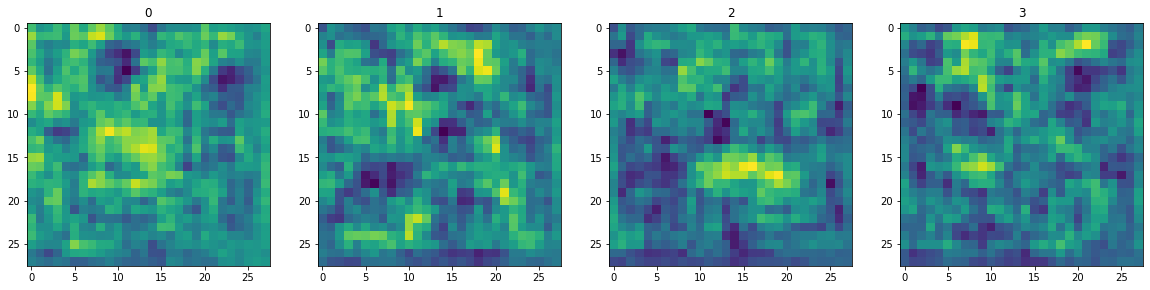

In [14]:
# Generate new fashion
img = generator.predict(np.random.randn(4,256,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [21]:
def build_discriminator(): 
    model = Sequential([
        Conv2D(32, 5, input_shape = (28,28,1)),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(64, 5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(128, 5),
        LeakyReLU(0.2),
        Dropout(0.4),

        Conv2D(256, 5),
        LeakyReLU(0.2),
        Dropout(0.4),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')])
    
    return model 

In [22]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_17 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 128)      

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [ ]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [ ]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128, 128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

### 4.3 Train 

In [ ]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

### 4.4 Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [ ]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')